<a href="https://colab.research.google.com/github/alex-mcintosh/Supervised-Learning-for-Student-Dropout/blob/main/Applying_supervised_learning_to_predict_student_dropout_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**First things first** - please go to 'File' and select 'Save a copy in Drive' so that you have your own version of this activity set up and ready to use.
Remember to update the portfolio index link to your own work once completed!

# Mini-project 6.3 Applying supervised learning to predict student dropout rate

**Welcome to your Mini-project: Applying supervised learning to predict student dropout rate!**

In this project, we will examine student data and use supervised learning techniques to predict whether a student will drop out. In the education sector, retaining students is vital for the institution's financial stability and for students’ academic success and personal development. A high dropout rate can lead to significant revenue loss, diminished institutional reputation, and lower overall student satisfaction.

Please set aside approximately **12 hours** to complete the mini-project.

<br></br>

## **Business context**
Study Group specialises in providing educational services and resources to students and professionals across various fields. The company's primary focus is on enhancing learning experiences through a range of services, including online courses, tutoring, and educational consulting. By leveraging cutting-edge technology and a team of experienced educators, Study Group aims to bridge the gap between traditional learning methods and the evolving needs of today's learners.

Study Group serves its university partners by establishing strategic partnerships to enhance the universities’ global reach and diversity. It supports the universities in their efforts to attract international students, thereby enriching the cultural and academic landscape of their campuses. It works closely with university faculty and staff to ensure that the universities are prepared and equipped to welcome and support a growing international student body. Its partnership with universities also offers international students a seamless transition into their chosen academic environment. Study Group runs several International Study Centres across the UK and Dublin in partnership with universities with the aim of preparing a pipeline of talented international students from diverse backgrounds for degree study. These centres help international students adapt to the academic, cultural, and social aspects of studying abroad. This is achieved by improving conversational and subject-specific language skills and academic readiness before students progress to a full degree programme at university.

Through its comprehensive suite of services, it supports learners and universities at every stage of their educational journey, from high school to postgraduate studies. Its approach is tailored to meet the unique needs of each learner, offering personalised learning paths and flexible scheduling options to accommodate various learning styles and commitments.

Study Group's services are designed to be accessible and affordable, making quality education a reality for many individuals. By focusing on the integration of technology and personalised learning, the company aims to empower learners to achieve their full potential and succeed in their academic and professional pursuits. Study Group is at the forefront of transforming how people learn and grow through its dedication to innovation and excellence.
Study Group has provided you a course-level data set.


<br></br>

## **Objective**
By the end of this mini-project, you will have developed the skills and knowledge to apply advanced machine learning techniques to create a predictive model for student dropout. This project will involve comprehensive data exploration, preprocessing, and feature engineering to ensure high-quality input for the models. You will employ and compare multiple predictive algorithms - XGBoost and neural network-based model, to determine the most effective model for predicting student dropout.

In the Notebook, you will:
- explore the data set
- preprocess the data and conduct feature engineering
- predict dropout using XGBoost, and neural network-based model
- Identify the most important predictors of dropout.


You will also write a report summarising the results of your findings and recommendations.

<br></br>

## **Assessment criteria**
By completing this project, you will be able to provide evidence that you can:
- develop accurate predictions across diverse organisational scenarios by building and testing advanced machine learning models
- inform data-driven decision-making with advanced machine learning algorithms and models
- propose and present effective solutions to organisational problems using data preprocessing, model selection, and insightful analysis techniques.

<br></br>

## **Project guidance**

Data preparation
1. Import the required libraries and data set with the provided URL.
  - Data set drive: https://drive.google.com/drive/folders/130AVMFxTOtRiC7GOl7QmSo0I7B0iChv5
2. Read the course-level csv file and make it available as a dataframe.

3. From the dataframe, remove the following columns:

columns= ['BookingId','BookingType', 'LeadSource', 'DiscountType',
                                                    'Nationality', 'HomeCountry',
                                                    'HomeState',
                                                    'HomeCity',
                                                    'PresentCount',
                                                    'LateCount', 'AuthorisedAbsenceCount','ArrivedDate','NonCompletionReason',
                                                    'TerminationDate',
                                                    'CourseFirstIntakeDate', 'CourseStartDate','CourseEndDate',
                                                    'AcademicYear', 'CourseName',
                                                    'LearnerCode', 'ProgressionDegree',
                                                    'EligibleToProgress',
                                                    'AssessedModules',
                                                    'PassedModules',
                                                    'FailedModules',
                                                    'AttendancePercentage',
                                                    'ContactHours']

From here on, you will perform the rest of the actvities mentioned in the rubric with the smaller set of features obtained after performing the above step.

General Instructions that apply throughout this project activity:
  - Use the standard scaler to scale your numeric input features.
  - Split the data into train and test sets. Apply 80-20 split.
  - Print accuracy, confusion matrix, precision, recall and AUC on the test set
    for all your models.
  - Compare the performance (on the test set) obtained from the non-optimised
    model with the best performing model. Record your observations. What differences do you see and which metrics are improved or not improved?

## Please refer to the Rubric for specific steps to be performed as part of the project activity. Every step mentioned in the rubric will be assessed separately.

Report
1. Document your approach and major inferences from the data analysis and describe which method provided the best results and why.
  - Please ensure you include a discussion around which of the features will predict student droput.
2. When you’ve completed the project:
  - Download your completed Notebook as an IPYNB (Jupyter Notebook) or PY (Python) file. Save the file as follows: **LastName_FirstName_CAM_C201_Week_6_Mini-project**.
  - Prepare a detailed report (between 800-1,000 words) that includes:
    - an overview of your approach
    - a description of your analysis
    - an explanation of the insights you identified
    - a summary of which method gave the best results
    - an explanation of visualisations you created.
  - Save the document as a PDF named according to the following convention: **LastName_FirstName_CAM_C201_Week_6_Mini-project.pdf**.
  


<br></br>
> **Declaration**
>
> By submitting your project, you indicate that the work is your own and has been created with academic integrity. Refer to the Cambridge plagiarism regulations.

# Data Input and Exploratory Data Analysis

In [ ]:
# Install and load required libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, roc_curve,
                             auc, classification_report, precision_score,
                              confusion_matrix, ConfusionMatrixDisplay)
from tensorflow import keras
from keras import layers, Sequential,optimizers
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
import random
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seed
keras.utils.set_random_seed(812)

In [ ]:
# Create functions for processes that will be used frequently and to keep the
# workbook tidy

def ROC_AUC(predictions, y_test, title):
    # Compute the ROC curve and the AUC score.
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    auc_score = roc_auc_score(y_test, predictions)
    auc_value = auc(fpr, tpr)

    # Plot the ROC curve and show the AUC score.
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    plt.legend()
    plt.show()

def prepare_data(df, y_var):
    # Split into X and y datasets
    X = df.drop([y_var], axis=1)
    y = df[y_var]
    # Split data into train and test, using stratify due to the class imbalance
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=42)
    # One hot encode data
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    # Get columns that are numeric in X_train
    numeric_cols = X_train.select_dtypes(include=['number']).columns
    # Scale numeric values
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train, X_test, y_train, y_test

def performance_metric(y_test, predictions, title):
    print(title, 'accuracy:', accuracy_score(y_test, predictions))
    print(title, 'f1:', f1_score(y_test, predictions))
    print(classification_report(y_test, predictions, digits=4))
    # Calculate and display confustion matrix
    cm = confusion_matrix(y_test, predictions)
    cfmd = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Completed Course", "Drop Out"])
    fig, ax = plt.subplots(figsize=(4,4))
    cfmd.plot(ax=ax, colorbar=False)
    plt.show()

In [ ]:
url = 'https://drive.google.com/uc?id=1rKxv26grdaO6KuN8ZGQX5C-eZ0N6o_hg&export=download'
# Open csv in the 'url' location
df = pd.read_csv(url)
df.head()

,CentreName,AcademicYear,LearnerCode,BookingId,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,...,CreditWeightedAverage,ProgressionDegree,ProgressionUniversity,EligibleToProgress,PresentCount,LateCount,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage
0,ISC_Aberdeen,2019/20,2284932,31261386,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,...,75.0,Msc Econ Accounting and Investment Management,University of Aberdeen,Yes,NaN,NaN,NaN,NaN,NaN,NaN
1,ISC_Aberdeen,2019/20,2399500,31979379,Agent,Standard Agent Booking,NaN,12/02/1998,Male,Chinese,...,73.0,BSc Biological Sciences,University of Aberdeen,Yes,80.0,0.0,93.0,5.0,215.0,97.0
2,ISC_Aberdeen,2019/20,2424946,27491184,Agent,Standard Agent Booking,NaN,07/04/2000,Male,Chinese,...,66.0,MA Finance,University of Aberdeen,Yes,88.0,0.0,92.0,6.0,226.0,97.0
3,ISC_Aberdeen,2019/20,2426583,28689190,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,...,71.0,MA Business Management,University of Aberdeen,Yes,164.0,12.0,67.0,15.0,399.0,94.0
4,ISC_Aberdeen,2019/20,2434674,35141670,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,...,60.0,MSc International Business Management,University of Aberdeen,Yes,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop columns specified above but leaving ContactHours and AttendancePercentage in place for now
col_list =  ['BookingId','BookingType', 'LeadSource', 'DiscountType',
             'Nationality', 'HomeCountry', 'HomeState', 'HomeCity',
             'PresentCount', 'LateCount', 'AuthorisedAbsenceCount',
             'ArrivedDate','NonCompletionReason', 'TerminationDate',
             'CourseFirstIntakeDate', 'CourseStartDate','CourseEndDate',
             'AcademicYear', 'CourseName', 'LearnerCode', 'ProgressionDegree',
             'EligibleToProgress', 'AssessedModules', 'PassedModules',
             'FailedModules']
# Create reduced dataset
red_df1 = df.drop(col_list, axis=1)
red_df1.head()

,CentreName,DateofBirth,Gender,CourseLevel,IsFirstIntake,CompletedCourse,CreditWeightedAverage,ProgressionUniversity,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage
0,ISC_Aberdeen,13/01/1998,Male,Pre-Masters,True,Yes,75.0,University of Aberdeen,NaN,NaN,NaN
1,ISC_Aberdeen,12/02/1998,Male,Foundation,False,Yes,73.0,University of Aberdeen,5.0,215.0,97.0
2,ISC_Aberdeen,07/04/2000,Male,International Year Two,False,Yes,66.0,University of Aberdeen,6.0,226.0,97.0
3,ISC_Aberdeen,18/05/1999,Male,International Year Two,True,Yes,71.0,University of Aberdeen,15.0,399.0,94.0
4,ISC_Aberdeen,19/04/1996,Male,Pre-Masters,True,Yes,60.0,University of Aberdeen,NaN,NaN,NaN


In [ ]:
# Print balance of Course completed to non completed
print(red_df1['CompletedCourse'].value_counts())

CompletedCourse
Yes    21305
No      3754
Name: count, dtype: int64


The classes appear to be imbalanced with $\sim 6\times$ as many students completing the course to not completing the course. This needs to be considered during the analysis.

In [ ]:
# Check data for duplicates
print(red_df1.duplicated().sum())

0


In [ ]:
# Count number of missing values for each column
print(red_df1.isnull().sum())

CentreName                     0
DateofBirth                    0
Gender                         0
CourseLevel                    0
IsFirstIntake                  0
CompletedCourse                0
CreditWeightedAverage       2296
ProgressionUniversity          0
UnauthorisedAbsenceCount     208
ContactHours                 208
AttendancePercentage         208
dtype: int64


In [ ]:
# Check if the 208 missing values in UnauthorisedAbsenceCount,
# AttendancePercentage and ContactHours are in the same rows
print(red_df1[red_df1['UnauthorisedAbsenceCount'].isnull()].isnull().sum())

CentreName                    0
DateofBirth                   0
Gender                        0
CourseLevel                   0
IsFirstIntake                 0
CompletedCourse               0
CreditWeightedAverage       131
ProgressionUniversity         0
UnauthorisedAbsenceCount    208
ContactHours                208
AttendancePercentage        208
dtype: int64


In [ ]:
# Print balance of Course completed to non completed
print('Balance of values for UnauthorisedAbsenceCount missing values:')
print(red_df1[red_df1['UnauthorisedAbsenceCount'].isnull()].isnull()['CompletedCourse'].value_counts())
print('Balance of values for ContactHours missing values:')
print(red_df1[red_df1['ContactHours'].isnull()].isnull()['CompletedCourse'].value_counts())
print('Balance of values for AttendancePercentage missing values:')
print(red_df1[red_df1['AttendancePercentage'].isnull()].isnull()['CompletedCourse'].value_counts())

Balance of values for UnauthorisedAbsenceCount missing values:
CompletedCourse
False    208
Name: count, dtype: int64
Balance of values for ContactHours missing values:
CompletedCourse
False    208
Name: count, dtype: int64
Balance of values for AttendancePercentage missing values:
CompletedCourse
False    208
Name: count, dtype: int64


All the missing values appear to be from the class of CompletedCourse = False, which suggests these values may not be missing at random (MNAR). This small number represents only 5.7% of this class. In the interests of pragmatism, these will be removed as imputing for all these fields may add too much complexity at this point for the relative gain in information for keeping them. All 208 missing values are also across the same 208 records, which simplifies their removal. This should be investigated further.



Since the rows with missing values in UnauthorisedAbsenceCount are the same as AttendancePercentage and ContactHours, these will be removed.
These values are also a small subset of the data, only representing  ≈0.8%  of the dataset.

In [ ]:
# Remove rows where red_df['UnauthorisedAbsenceCount'].isnull()
red_df1 = red_df1.dropna(subset=['UnauthorisedAbsenceCount'])

In [ ]:
# Count number of missing values for each column
print(red_df1.isnull().sum())

CentreName                     0
DateofBirth                    0
Gender                         0
CourseLevel                    0
IsFirstIntake                  0
CompletedCourse                0
CreditWeightedAverage       2165
ProgressionUniversity          0
UnauthorisedAbsenceCount       0
ContactHours                   0
AttendancePercentage           0
dtype: int64


In [ ]:
# Filter on CreditWeightedAverage = null value and find out the split in completedcourse
red_df1[red_df1['CreditWeightedAverage'].isnull()]['CompletedCourse'].value_counts()

,count
CompletedCourse,
No,2165


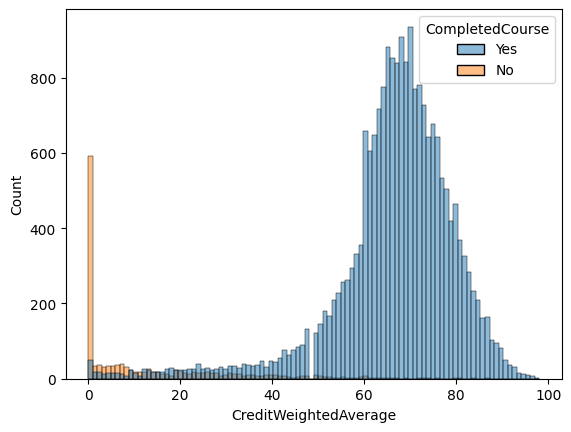

In [ ]:
# Plot the distribution of the CreditWeightedAverage by whether the student completed the course or not.
sns.histplot(data=red_df1, x='CreditWeightedAverage', hue='CompletedCourse')
plt.show()

The CreditWeightedAverage values appear to have different distributions depending on whether the student completed the course. Since all the values that are missing are from the CompletedCourse = False class it appears that the values missing from the CreditWeightedAverage column are likely Missing Not at Random (MNAR).

**Removing these would eliminate 60 % of the CompletedCourse = False records and may also introduce bias.**
This needs to be investigated further. Possible approaches to this include:

*   Modelling the 'missing' behaviour
*   Complete removal of this feature

**The missing values will be replaced with the median values for the CompletedCourse = False class in a basic attempt to model the missing behavior. This should be investigated further and considered when assessing the models used**

In [ ]:
# Find median value for the false values in 'CreditWeightedAverage' column of red_df1
median_false = red_df1[red_df1['CompletedCourse'] == 'No']['CreditWeightedAverage'].median()
# Replace missing values with the median value for CreditWeightedAverage
red_df1 = red_df1.fillna(median_false)

In [ ]:
# Convert DateofBirth to date format
red_df1[['DateofBirth']] = red_df1[['DateofBirth']].apply(pd.to_datetime, format='%d/%m/%Y')
# Create new column called Age and drop date of birth
red_df1['Age'] = (datetime.today() - red_df1['DateofBirth']).dt.days/365.25
red_df1 = red_df1.drop(['DateofBirth'], axis=1)

In [ ]:
# Output the number of unique entries for each column
red_df1.nunique()

,0
CentreName,19
Gender,2
CourseLevel,4
IsFirstIntake,2
CompletedCourse,2
CreditWeightedAverage,99
ProgressionUniversity,39
UnauthorisedAbsenceCount,258
ContactHours,658
AttendancePercentage,100


CentreName only has 19 unique values so is okay to one hot encode as is. Progression University needs to be reduced slightly.

In [ ]:
# List ProgressionUniversity by number for each unique entry
red_df1['ProgressionUniversity'].value_counts().head(20)

,count
ProgressionUniversity,
University of Sheffield International College,5872
Durham University,2555
University of Sussex,2086
Kingston University London,1859
University of Huddersfield,1752
University of Leeds,1586
Lancaster University,1114
University of Surrey,1047
Royal Holloway,1040


In [ ]:
# Arbitarly reduce the number of categories to twenty and relabel the bottom
# categories with less than 100 as 'other'
red_df1['ProgressionUniversity'] = (
    red_df1['ProgressionUniversity'].apply(
        lambda x: 'Other' if red_df1[
            'ProgressionUniversity'
        ].value_counts().get(x, 0) < 100 else x
    )
)

### Histograms of the Features

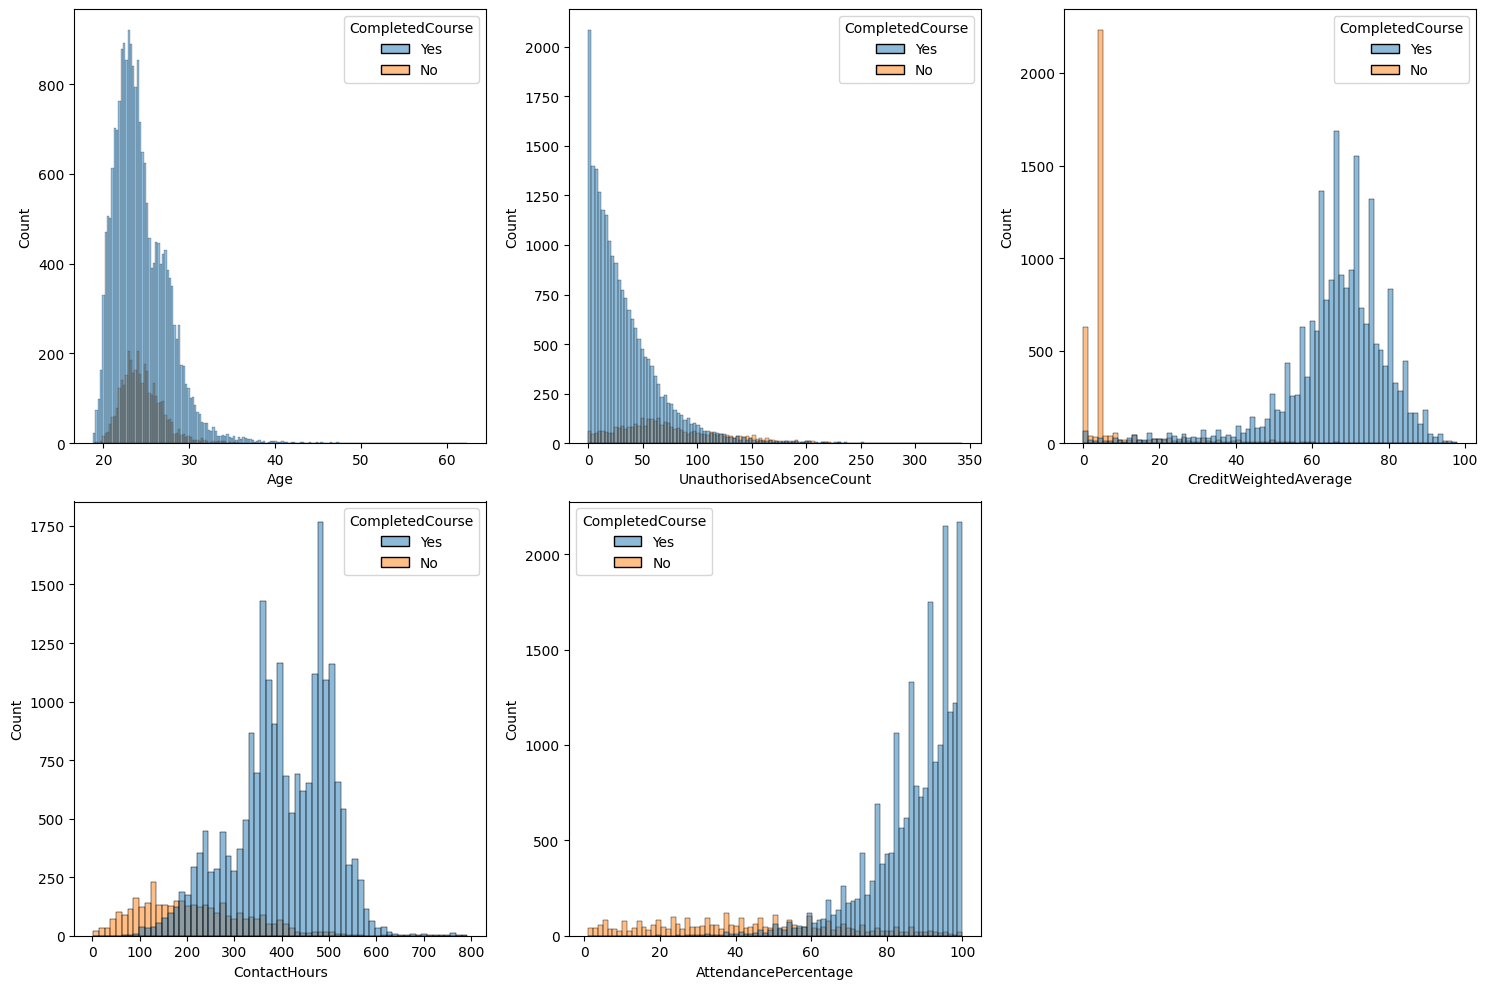

In [ ]:
# Plot histogram plots for the each numerical feature
col_names = ['Age',
             'UnauthorisedAbsenceCount',
             'CreditWeightedAverage',
             'ContactHours',
             'AttendancePercentage']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(col_names):
    row = i // 3
    col_num = i % 3
    sns.histplot(data=red_df1, x=col, hue='CompletedCourse', ax=axes[row, col_num])
fig.delaxes(axes[1,2])
plt.tight_layout()
plt.show()

The histograms provide interesting insights into the features of the two classes of CompletedCourse.

**Age** - This appears bimodal for the CompletedCourse = True class, both differences have a right skew. Visually, there is little to separate the classes based on age.

**UnauthorisedAbsenceCount** - These distributions appear to have a Poisson type of distribution, with each class having very different expected values. The CompletedCourse = True having a lower number of unauthorised absences than those who failed to complete the course.

**CreditWeightedAverage** - For the records which completed the course this follows a normal distribution, as would be expected for this type of feature. The distribution for the CompletedCourse = False is very different and it is difficult to determine what distribution would be most effective at modelling this.

**ContactHours** - For the records that completed the course this appears to have a complex multimodal distribution, which may reflect different expectations of contact hours at differenct institutions and courses. For the records which have CompletedCourse = False the average contact hours is much lower and the distribution appears to be unimodal.

**AttendencePercentage** - The two classes in this feature have very different attributes and both could potentially be modelled by a beta distribution.

### Boxplots of the Features

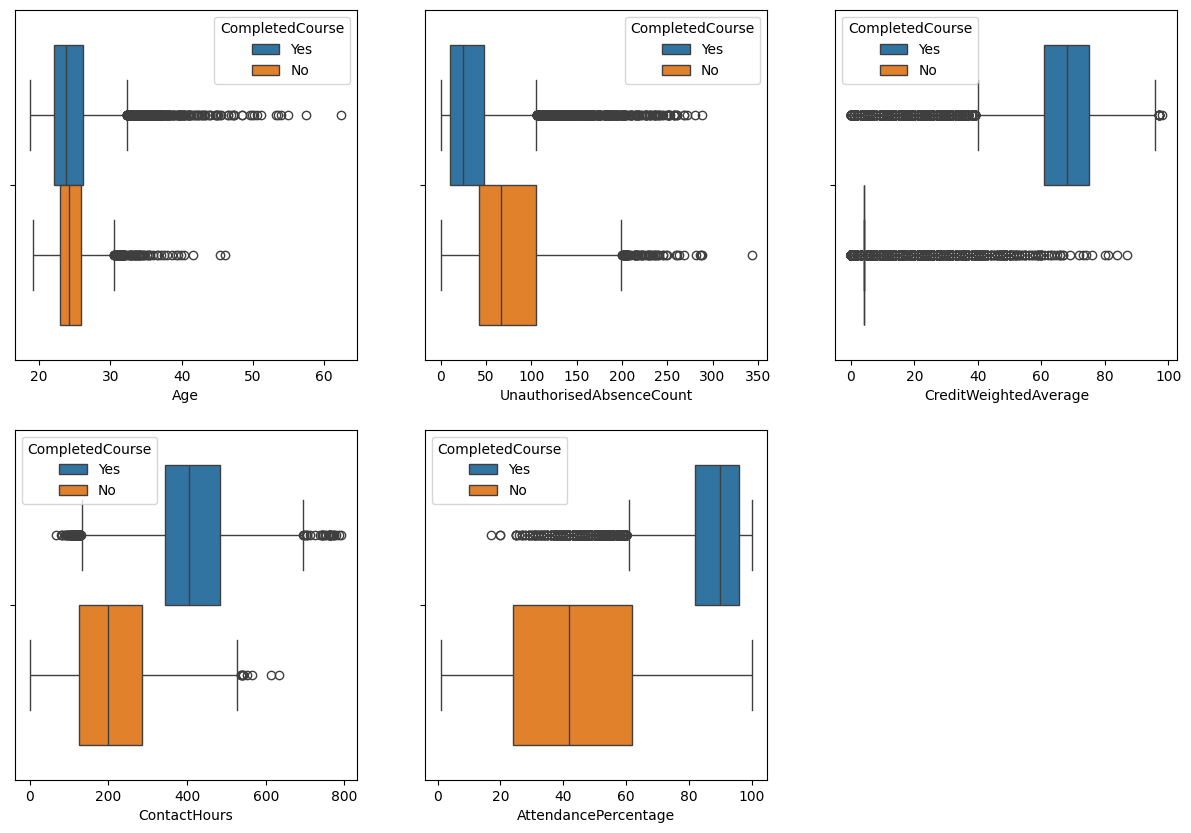

In [ ]:
# Plot boxplots for each numerical feature
col_names = ['Age',
             'UnauthorisedAbsenceCount',
             'CreditWeightedAverage',
             'ContactHours',
             'AttendancePercentage']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(col_names):
    row = i // 3
    col_num = i % 3
    sns.boxplot(data=red_df1, x=col, hue='CompletedCourse', ax=axes[row, col_num])
fig.delaxes(axes[1,2])

plt.show()

The boxplots further emphasise the histogram differences between the two classes for each numerical feature. All the features, except Age, have very distinctive differences between the classes. Most features have many outliers, using $1.5 \times IQR$ (the whiskers) as a cut-off. However, it is notable that the CompletedCourse = False class for the attendance percentage did not contain any outliers; for this feature, the difference in variance between the classes is also much larger than for other features.



### Count Plots

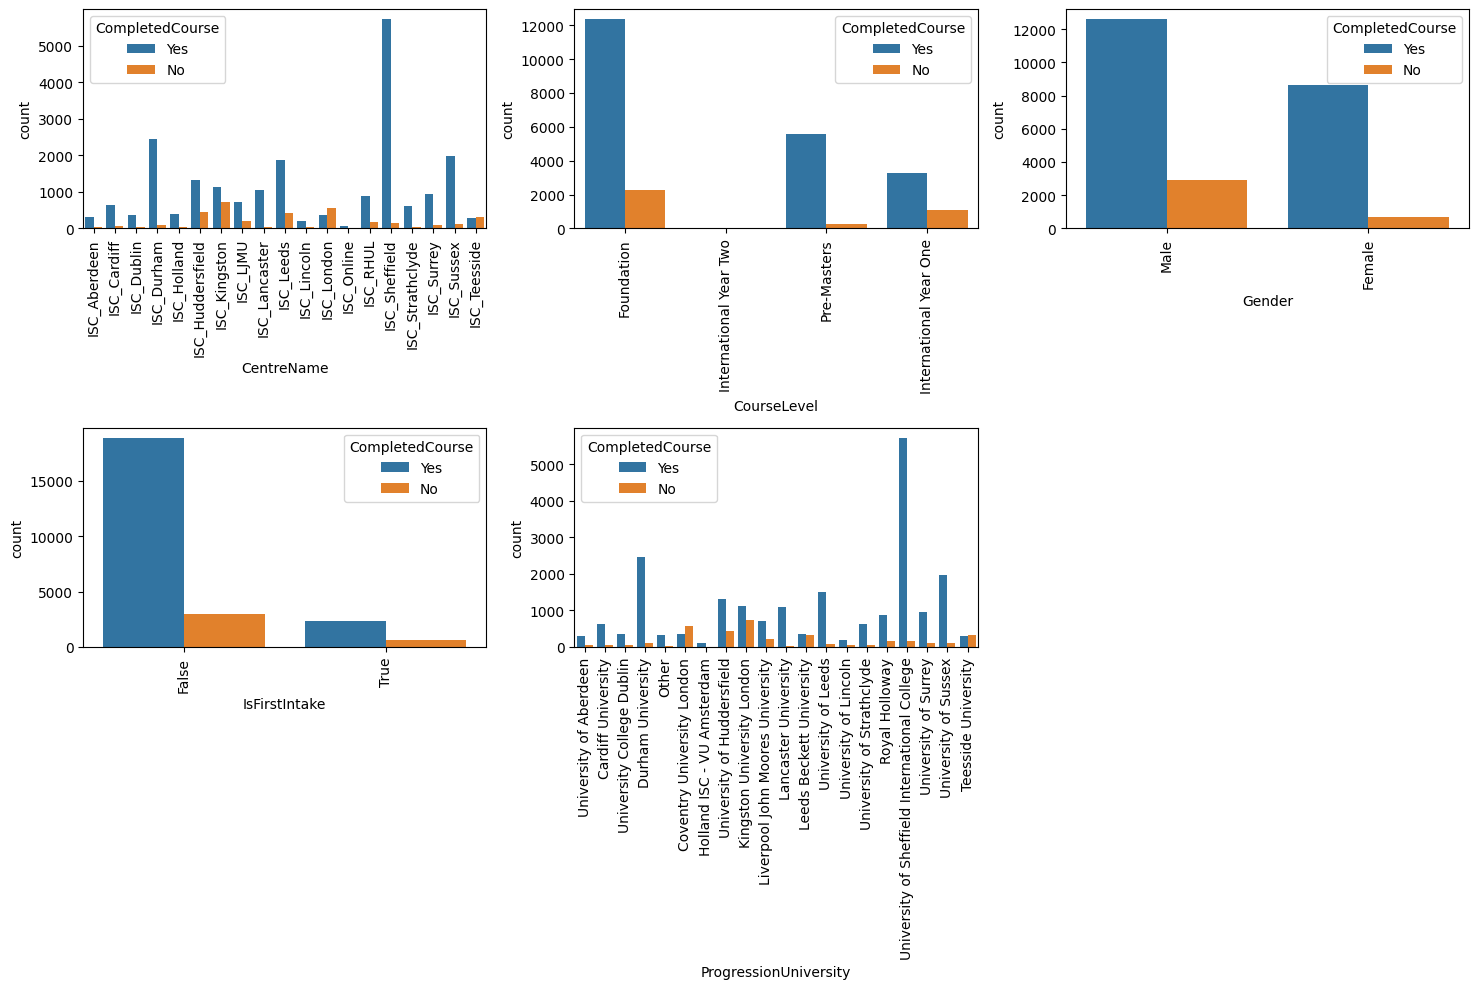

In [ ]:
# Plot count plots for each categorical feature
col_names = ['CentreName',
             'CourseLevel',
             'Gender',
             'IsFirstIntake',
             'ProgressionUniversity']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(col_names):
    row = i // 3
    col_num = i % 3
    sns.countplot(data=red_df1, x=col, hue='CompletedCourse', ax=axes[row, col_num])
    axes[row, col_num].set_xticklabels(axes[row, col_num].get_xticklabels(), rotation=90)

fig.tight_layout()
fig.delaxes(axes[1,2])
plt.show()

The categorical data is harder to distinguish. At first, there are differences between the classes. However, some interesting observations show some distinctive features. For example, certain institutions, such as Teesside University and Kingston University London, have relatively high student dropout rates.
It is also noted that visually, many of the trends observed in ProgressionUniversity are also mirrored in the CentreName feature. This suggests a certain amount of colinearity between these features. This should be investigated further, as it may be an opportunity to reduce dimensionality and complexity.

In [ ]:
# Convert CompletedCourse to zero and one with the majority class being 0 (Yes) and the minority class being 1 (No)
red_df1['CompletedCourse'] = red_df1['CompletedCourse'].map({'Yes': 0, 'No': 1})
# Rename this to StudentDropOut
red_df1 = red_df1.rename(columns={'CompletedCourse': 'StudentDropOut'})

In [ ]:
# Create a new 'minmal' dataset without ContactHours and AttendancePercentage
red_df2 = red_df1.drop(['ContactHours', 'AttendancePercentage'], axis=1)

# XGBoost Model

## XGBoost Model with the Minimal Dataset

Here XGBoost will be used for classification of the Study Group data CentreName, Gender, CourseLevel, IsFirstIntake, CreditWeightedAverage, ProgressionUniversity, UnauthorisedAbsenceCount and Age Features.



In [ ]:
# Prepare the train and test set from the minimal dataset red_df2
X_train2, X_test2, y_train2, y_test2 = prepare_data(red_df2, 'StudentDropOut')
# Create a validation train and test data
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2,
                                                      y_train2,
                                                      test_size=0.2,
                                                      stratify=y_train2,
                                                      random_state=42)

XGBoost is first used on the data without any optimisation.

XGBoost Model accuracy: 0.972037819352243
XGBoost Model f1: 0.9016277423920736
              precision    recall  f1-score   support

           0     0.9801    0.9873    0.9837      4249
           1     0.9219    0.8823    0.9016       722

    accuracy                         0.9720      4971
   macro avg     0.9510    0.9348    0.9427      4971
weighted avg     0.9717    0.9720    0.9718      4971



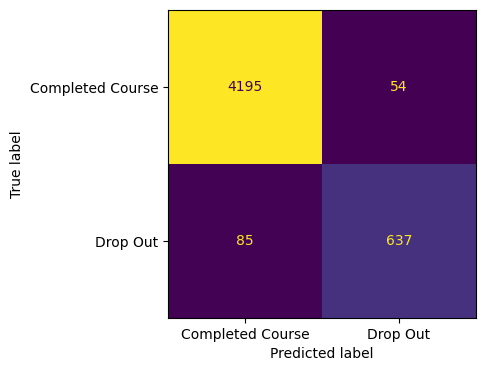

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_set=[(X_val2, y_val2)])
xgb_model.fit(X_train2, y_train2)

predictions = xgb_model.predict(X_test2)
# Plot confustion matrix and performance metrics
performance_metric(y_test2, predictions, "XGBoost Model")

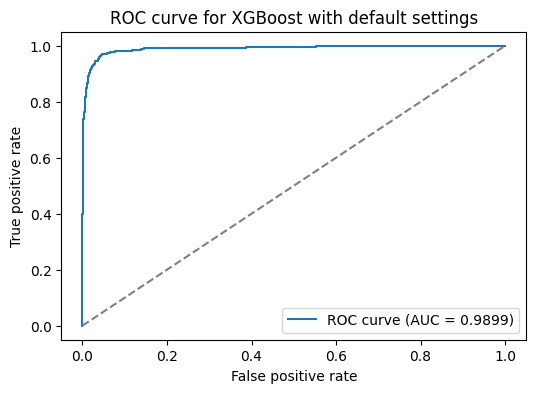

In [ ]:
# Predict the probabilities of the positive class on the test set.
y_proba = xgb_model.predict_proba(X_test2)[:, 1]
# Plot ROC curve and AUC
ROC_AUC(y_proba, y_test2, 'ROC curve for XGBoost with default settings')

Using default settings the XGBoost produces okay predictions. Due to the class imbalance the F1 score and ROC-AUC will be used as metrics for the models.

### Tuning of the Hyperparameters with the Minimal Dataset

Here, the hyperparameters for the neural network will be tuned semi-manually by iterating through vectors for each parameter and setting once optimised. This may not yield the optimal parameters that a grid search would yield, but it is used here to simplify computation (Using GridSearchCV was found to be too computational intensive in Colab).

Best set of hyperparameters:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 75}
Best score:  0.913850398670616
XGBoost Model Accuracy:  accuracy: 0.9714343190504928
XGBoost Model Accuracy:  f1: 0.89900426742532
              precision    recall  f1-score   support

           0     0.9790    0.9878    0.9834      4249
           1     0.9240    0.8753    0.8990       722

    accuracy                         0.9714      4971
   macro avg     0.9515    0.9316    0.9412      4971
weighted avg     0.9710    0.9714    0.9711      4971



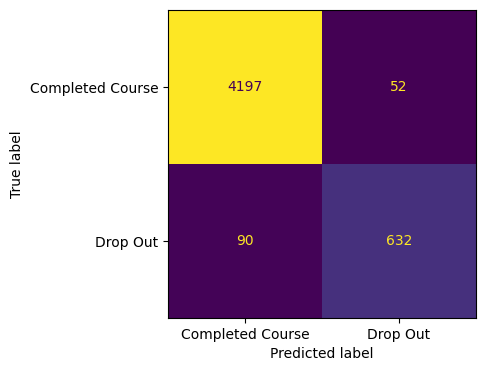

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.4, 0.3, 0.2, 0.1, 0.01],
    'n_estimators': [10, 25, 50, 75, 100, 125]
}

# Create the GridSearchCV object, f1 scoring is used due to the imbalance of the
# dataset
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train2, y_train2)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

predictions = grid_search.predict(X_test2)
# Plot confustion matrix and performance metrics
performance_metric(y_test2, predictions, "XGBoost Model Accuracy: ")


In [ ]:
# Iterate through different max depths.
max_depth_list = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
best_f1 = 0
best_model = None
best_param = None
for max_depth in max_depth_list:
    print(f"\nTraining model with max depth of {max_depth}...")
    model = xgb.XGBClassifier(max_depth=max_depth,
                              random_state=42,
                              eval_set=[(X_val2, y_val2)])

    # Train the model.
    model.fit(X_train2, y_train2, verbose=0)

    # Evaluate the model using the validation set
    predictions = model.predict(X_test2)
    f1_sc = f1_score(y_test2, predictions)
    print(f"Model with {max_depth} max depth - f1 score: {f1_sc}")

    # If current model has higher f1 score, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = max_depth

print(f"\nBest model found with f1 score: {best_f1} and max depth {best_param}")


Training model with max depth of 3...
Model with 3 max depth - f1 score: 0.9031339031339032

Training model with max depth of 4...
Model with 4 max depth - f1 score: 0.9016277423920736

Training model with max depth of 5...
Model with 5 max depth - f1 score: 0.8959660297239915

Training model with max depth of 6...
Model with 6 max depth - f1 score: 0.9016277423920736

Training model with max depth of 7...
Model with 7 max depth - f1 score: 0.8956706884315118

Training model with max depth of 8...
Model with 8 max depth - f1 score: 0.8956706884315118

Training model with max depth of 9...
Model with 9 max depth - f1 score: 0.8954802259887006

Training model with max depth of 10...
Model with 10 max depth - f1 score: 0.89484827099506

Training model with max depth of 11...
Model with 11 max depth - f1 score: 0.8918727915194347

Training model with max depth of 12...
Model with 12 max depth - f1 score: 0.8912429378531074

Training model with max depth of 13...
Model with 13 max depth - 

Here, a max depth of 3 was found to be optimal, so it will be used for the next tuning phase, which focuses on the learning rate.

In [ ]:
# Iterate through different learning rates.
learning_rate_list = [0.5, 0.3, 0.2, 0.1, 0.01]
best_f1 = 0
best_model = None
best_param = None
for learning_rate in learning_rate_list:
    print(f"\nTraining model with a learning rate of {learning_rate}...")
    model = xgb.XGBClassifier(max_depth=3,
                              learning_rate=learning_rate,
                              random_state=42,
                              eval_set=[(X_val2, y_val2)])

    # Train the model.
    model.fit(X_train2, y_train2, verbose=0)

    # Evaluate the model using the validation set
    predictions = model.predict(X_test2)
    f1_sc = f1_score(y_test2, predictions)
    print(f"Model with {max_depth} layers - f1 score: {f1_sc}")

    # If current model has higher accuracy, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = learning_rate

print(f"\nBest model found with f1 score: {best_f1} and learning rate {best_param}")


Training model with a learning rate of 0.5...
Model with 14 layers - f1 score: 0.8978723404255319

Training model with a learning rate of 0.3...
Model with 14 layers - f1 score: 0.9031339031339032

Training model with a learning rate of 0.2...
Model with 14 layers - f1 score: 0.900709219858156

Training model with a learning rate of 0.1...
Model with 14 layers - f1 score: 0.8985095812633073

Training model with a learning rate of 0.01...
Model with 14 layers - f1 score: 0.8833087149187593

Best model found with f1 score: 0.9031339031339032 and learning rate 0.3


Here, a learning rate of 0.3 was found to be optimal, so it will be used for the next tuning phase, which will focus on the number of estimators.

In [ ]:
# Iterate through different n_estimators rates.
n_estimators_list = [10, 25, 50, 75, 100, 125, 150]
best_f1 = 0
best_model = None
best_param = None
for n_estimators in n_estimators_list:
    print(f"\nTraining model with {n_estimators} n_estimators...")
    model = xgb.XGBClassifier(max_depth=3,
                              learning_rate=0.3,
                              n_estimators=n_estimators,
                              random_state=42,
                              eval_set=[(X_val2, y_val2)])

    # Train the model.
    model.fit(X_train2, y_train2, verbose=0)

    # Evaluate the model.
    predictions = model.predict(X_test2)
    f1_sc = f1_score(y_test2, predictions)
    print(f"Model with {max_depth} layers - f1 score: {f1_sc}")

    # If current model has higher accuracy, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = n_estimators

print(f"\nBest model found with f1 score: {best_f1} and n_estimators {best_param}")


Training model with 10 n_estimators...
Model with 14 layers - f1 score: 0.8962061560486757

Training model with 25 n_estimators...
Model with 14 layers - f1 score: 0.9004267425320057

Training model with 50 n_estimators...
Model with 14 layers - f1 score: 0.900709219858156

Training model with 75 n_estimators...
Model with 14 layers - f1 score: 0.9012082444918266

Training model with 100 n_estimators...
Model with 14 layers - f1 score: 0.9031339031339032

Training model with 125 n_estimators...
Model with 14 layers - f1 score: 0.902491103202847

Training model with 150 n_estimators...
Model with 14 layers - f1 score: 0.901067615658363

Best model found with f1 score: 0.9031339031339032 and n_estimators 100


XGBoost Model accuracy: 0.9726413196539931
XGBoost Model f1: 0.9031339031339032
              precision    recall  f1-score   support

           0     0.9795    0.9887    0.9841      4249
           1     0.9296    0.8781    0.9031       722

    accuracy                         0.9726      4971
   macro avg     0.9546    0.9334    0.9436      4971
weighted avg     0.9722    0.9726    0.9723      4971



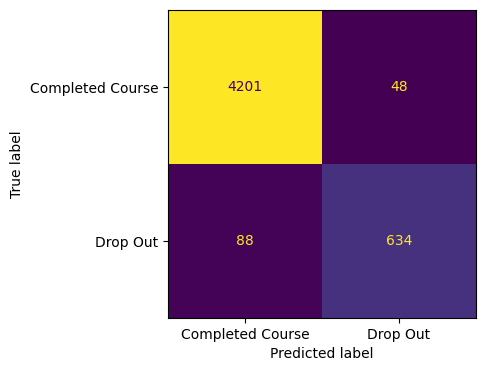

In [ ]:
# Use the best model to run predictions on the test set
predictions = best_model.predict(X_test2)
# Plot confustion matrix and performance metrics
performance_metric(y_test2, predictions, "XGBoost Model")

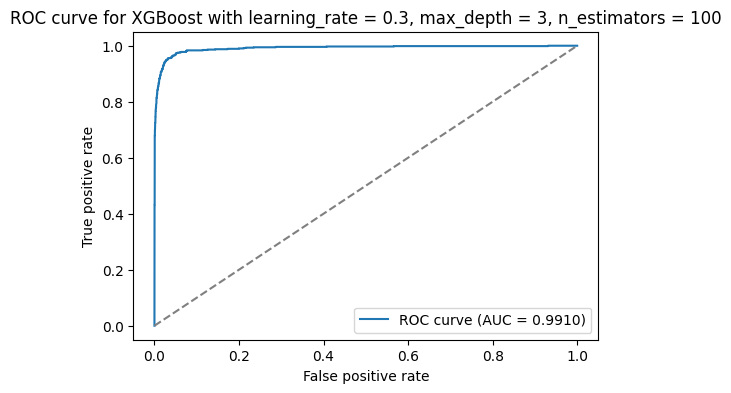

In [ ]:
# Predict the probabilities of the positive class on the test set.
y_proba = best_model.predict_proba(X_test2)[:, 1]

ROC_AUC(y_proba,
        y_test2,
        f"ROC curve for XGBoost with learning_rate = 0.3, max_depth = 3, n_estimators = 100")


## XGBoost Model with the Extended Dataset

Here, XGBoost will be used to classify the same Study Group data but with the inclusion of the ContactHours and AttendancePercentage features.

In [ ]:
# Create new train and test sets based on the extended dataset which also
# includes ContactHours and AttendencePercentage
X_train1, X_test1, y_train1, y_test1 = prepare_data(red_df1, 'StudentDropOut')
# Create a validation train and test data
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1,
                                                      y_train1,
                                                      test_size=0.2,
                                                      stratify=y_train1,
                                                      random_state=42)

XGBoost Model (Extended Dataset) accuracy: 0.9798833232749949
XGBoost Model (Extended Dataset) f1: 0.9295774647887324
              precision    recall  f1-score   support

           0     0.9855    0.9911    0.9883      4249
           1     0.9456    0.9141    0.9296       722

    accuracy                         0.9799      4971
   macro avg     0.9655    0.9526    0.9589      4971
weighted avg     0.9797    0.9799    0.9797      4971



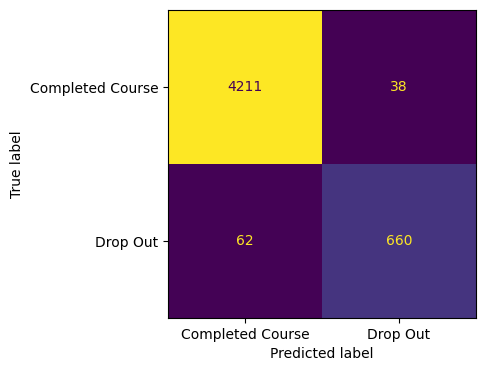

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_set=[(X_val1, y_val1)])
xgb_model.fit(X_train1, y_train1)

# Model evaluation
predictions = xgb_model.predict(X_test1)
# Plot confustion matrix and performance metrics
performance_metric(y_test1, predictions, "XGBoost Model (Extended Dataset)")

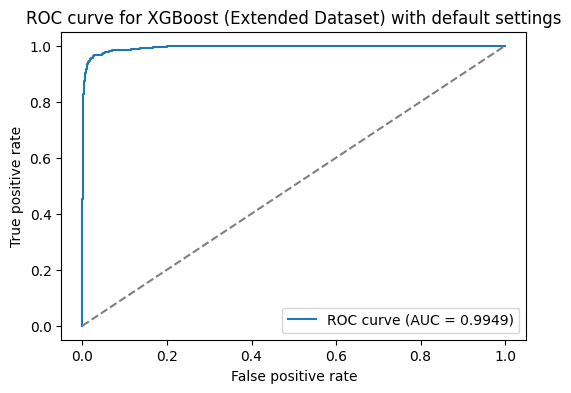

In [ ]:
# Predict the probabilities of the positive class on the test set.
y_proba = xgb_model.predict_proba(X_test1)[:, 1]

ROC_AUC(y_proba, y_test1, 'ROC curve for XGBoost (Extended Dataset) with default settings')

The introduction of the additional features positively impacts the F1 score and ROC-AUC, with increases in both relative to the minimal dataset model.

### Tuning of the Hyperparameters with the Extended Dataset

Here, the hyperparameters for the XGBoost model will be tuned in the same manner as those used for the minimal dataset.

In [ ]:
# Iterate through different max depths.
max_depth_list = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
best_f1 = 0
best_model = None
best_param = None
for max_depth in max_depth_list:
    print(f"\nTraining model with max depth of {max_depth}...")
    model = xgb.XGBClassifier(max_depth=max_depth,
                              random_state=42,
                              eval_set=[(X_val1, y_val1)])

    # Train the model.
    model.fit(X_train1, y_train1, verbose=0)

    # Evaluate the model using the validation set
    predictions = model.predict(X_test1)
    f1_sc = f1_score(y_test1, predictions)
    print(f"Model with {max_depth} max depth - f1 score: {f1_sc}")

    # If current model has higher f1 score, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = max_depth

print(f"\nBest model found with f1 score: {best_f1} and max depth {best_param}")


Training model with max depth of 3...
Model with 3 max depth - f1 score: 0.9295774647887324

Training model with max depth of 4...
Model with 4 max depth - f1 score: 0.9274136715997181

Training model with max depth of 5...
Model with 5 max depth - f1 score: 0.9311797752808989

Training model with max depth of 6...
Model with 6 max depth - f1 score: 0.9295774647887324

Training model with max depth of 7...
Model with 7 max depth - f1 score: 0.9289232934553132

Training model with max depth of 8...
Model with 8 max depth - f1 score: 0.9278206026629292

Training model with max depth of 9...
Model with 9 max depth - f1 score: 0.9295774647887324

Training model with max depth of 10...
Model with 10 max depth - f1 score: 0.9263157894736842

Training model with max depth of 11...
Model with 11 max depth - f1 score: 0.9276177090653549

Training model with max depth of 12...
Model with 12 max depth - f1 score: 0.9235087719298246

Training model with max depth of 13...
Model with 13 max depth 

Here, a max depth of 5 was found to be optimal, so it will be used for the next tuning phase, which will focus on the learning rate.

In [ ]:
# Iterate through different learning rates.
learning_rate_list = [0.5, 0.3, 0.2, 0.1, 0.01]
best_f1 = 0
best_model = None
best_param = None
for learning_rate in learning_rate_list:
    print(f"\nTraining model with a learning rate of {learning_rate}...")
    model = xgb.XGBClassifier(max_depth=5,
                              learning_rate=learning_rate,
                              random_state=42,
                              eval_set=[(X_val1, y_val1)])

    # Train the model.
    model.fit(X_train1, y_train1, verbose=0)

    # Evaluate the model using the validation set
    predictions = model.predict(X_test1)
    f1_sc = f1_score(y_test1, predictions)
    print(f"Model with {max_depth} layers - f1 score: {f1_sc}")

    # If current model has higher accuracy, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = learning_rate

print(f"\nBest model found with f1 score: {best_f1} and learning rate {best_param}")


Training model with a learning rate of 0.5...
Model with 14 layers - f1 score: 0.9284712482468443

Training model with a learning rate of 0.3...
Model with 14 layers - f1 score: 0.9311797752808989

Training model with a learning rate of 0.2...
Model with 14 layers - f1 score: 0.9305263157894736

Training model with a learning rate of 0.1...
Model with 14 layers - f1 score: 0.9253521126760563

Training model with a learning rate of 0.01...
Model with 14 layers - f1 score: 0.9017595307917888

Best model found with f1 score: 0.9311797752808989 and learning rate 0.3


Here, a learning rate of 0.3 was found to be optimal, so it will be used for the next tuning phase, which will focus on the number of estimators.

In [ ]:
# Iterate through different n_estimators rates.
n_estimators_list = [10, 25, 50, 75, 100, 125, 150]
best_f1 = 0
best_model = None
best_param = None
for n_estimators in n_estimators_list:
    print(f"\nTraining model with {n_estimators} n_estimators...")
    model = xgb.XGBClassifier(max_depth=5,
                              learning_rate=0.3,
                              n_estimators=n_estimators,
                              random_state=42,
                              eval_set=[(X_val2, y_val2)])

    # Train the model.
    model.fit(X_train1, y_train1, verbose=0)

    # Evaluate the model.
    predictions = model.predict(X_test1)
    f1_sc = f1_score(y_test1, predictions)
    print(f"Model with {max_depth} layers - f1 score: {f1_sc}")

    # If current model has higher accuracy, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = n_estimators

print(f"\nBest model found with f1 score: {best_f1} and n_estimators {best_param}")


Training model with 10 n_estimators...
Model with 14 layers - f1 score: 0.9097320169252469

Training model with 25 n_estimators...
Model with 14 layers - f1 score: 0.9167842031029619

Training model with 50 n_estimators...
Model with 14 layers - f1 score: 0.9249122807017544

Training model with 75 n_estimators...
Model with 14 layers - f1 score: 0.9304286718200984

Training model with 100 n_estimators...
Model with 14 layers - f1 score: 0.9311797752808989

Training model with 125 n_estimators...
Model with 14 layers - f1 score: 0.9326788218793829

Training model with 150 n_estimators...
Model with 14 layers - f1 score: 0.9338028169014084

Best model found with f1 score: 0.9338028169014084 and n_estimators 150


XGBoost Model accuracy: 0.9810903238784953
XGBoost Model f1: 0.9338028169014084
              precision    recall  f1-score   support

           0     0.9862    0.9918    0.9890      4249
           1     0.9499    0.9183    0.9338       722

    accuracy                         0.9811      4971
   macro avg     0.9680    0.9550    0.9614      4971
weighted avg     0.9809    0.9811    0.9810      4971



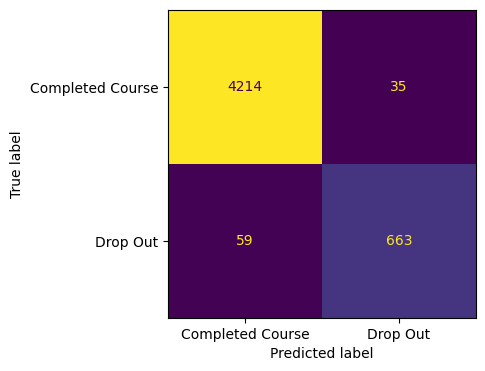

In [ ]:
predictions = best_model.predict(X_test1)
# Plot confustion matrix and performance metrics
performance_metric(y_test1, predictions, "XGBoost Model")

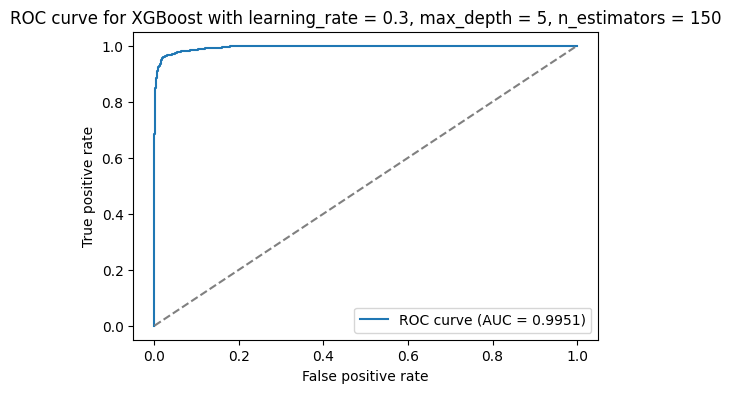

In [ ]:
# Predict the probabilities of the positive class on the test set.
y_proba = best_model.predict_proba(X_test1)[:, 1]

ROC_AUC(y_proba,
        y_test2,
        f"ROC curve for XGBoost with learning_rate = 0.3, max_depth = 5, n_estimators = 150")


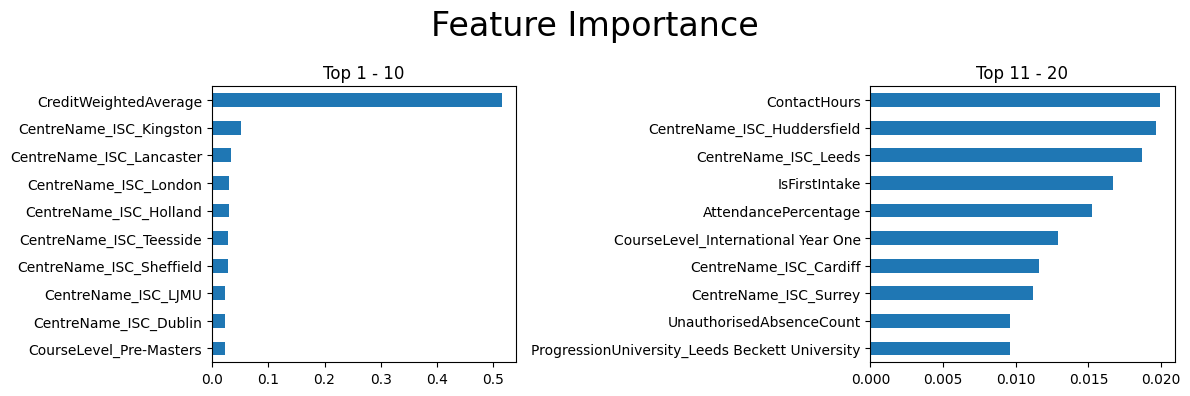

In [ ]:
feature_importance = pd.Series(best_model.feature_importances_,
                               index=X_train1.columns).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
feature_importance.iloc[-10:].plot.barh(ax=axes[0], title='Top 1 - 10')
feature_importance.iloc[-20:-10].plot.barh(ax=axes[1], title='Top 11 - 20')
fig.suptitle('Feature Importance', fontsize=24)
fig.tight_layout()
plt.show()


As can be seen, CreditWeightedAverage has a disproportionate influence on the classification compared to the other features. The next eight features originated from the CentreName features. It is noted that CentreName is significantly more dominant in the feature importance than ProgressionUniverisity. If these features do exhibit some collinearity, as visually suggested above. It may be possible to reduce these two dimensions into one, reducing model complexity.

# Neural Network Model

## Neural Network Model with the Minimal Dataset

Here, a neural network will be used to classify the Study Group data CentreName, Gender, CourseLevel, IsFirstIntake, CreditWeightedAverage, ProgressionUniversity, UnauthorisedAbsenceCount, and Age Features.

The dataset used for training and testing the XGBoost model with the minimal dataset will be used again for this neural network model.


In [ ]:
#The dataset used for training and testing the XGBoost model with the minimal
# dataset will be used again for this neural network model.

# Create a basic neural network model

def create_model(dim, optimizer='adam', neurons=64, activation='relu'):
  model = Sequential()
  model.add(Dense(neurons * 2, input_dim=dim , activation=activation))
  model.add(Dense(neurons, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [ ]:
# Define function to train the model and return history.
def train_model(model, X_train, y_train, X_val, y_val,
                epochs=50, batch_size=32):
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=0)
    return history

In [ ]:
# Train the model on the minimal dataset
history = train_model(create_model(dim= X_train2.shape[1],
                                   neurons = 45),
                      X_train=X_train2,
                      y_train=y_train2,
                      X_val=X_val2,
                      y_val=y_val2)

Text(0, 0.5, 'Accuracy')

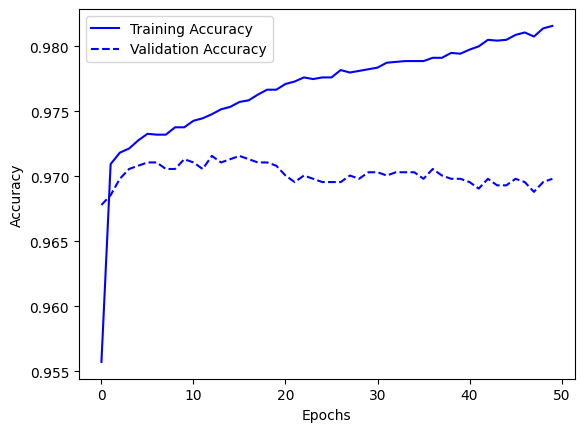

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'],
         label='Validation Accuracy',
         color='blue',
         linestyle='--')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

From the plot above, training the model with about five epochs would seem sensible, as overfitting seems to occur beyond this. Using this model, we get the baseline metrics shown below.

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Neural Network Model:  accuracy: 0.9702273184469925
Neural Network Model:  f1: 0.9002695417789758
              precision    recall  f1-score   support

           0     0.9872    0.9779    0.9825      4249
           1     0.8766    0.9252    0.9003       722

    accuracy                         0.9702      4971
   macro avg     0.9319    0.9515    0.9414      4971
weighted avg     0.9711    0.9702    0.9706      4971



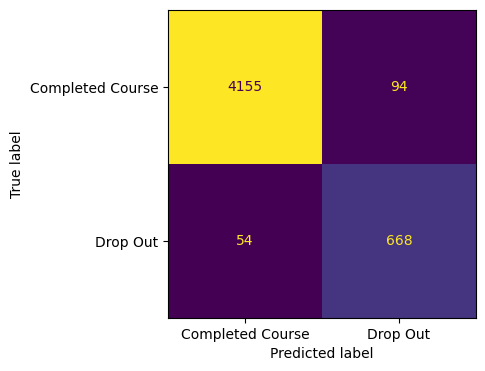

In [ ]:
# Fit the model on the whole  of the minimal training dataset with 5 epochs
model_nn = create_model(dim=X_train2.shape[1], optimizer='Adam')
model_nn.fit(X_train2, y_train2, epochs=5, batch_size=32, verbose=0)
predictions = model_nn.predict(X_test2)
predictions = (predictions > 0.5).astype(int)
# Plot confustion matrix and performance metrics
performance_metric(y_test2, predictions, "Neural Network Model: ")

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


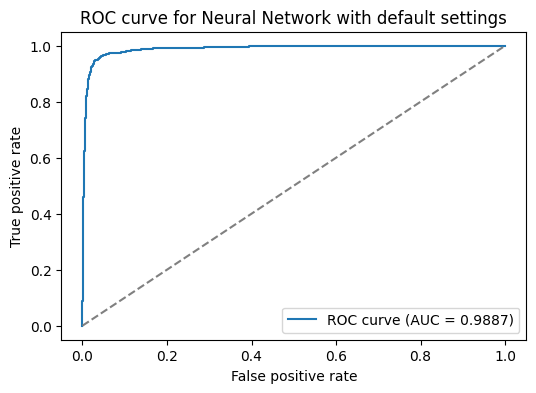

In [ ]:
predictions = model_nn.predict(X_test2)
ROC_AUC(predictions,
        y_test2,
        'ROC curve for Neural Network with default settings')

Initial metrics for the neural network model are worse than the XGBoost model.

### Tuning of the Hyperparameters with the Minimal Dataset

Here, the neural network's hyperparameters will be tuned semi-manually by iterating through vectors for each parameter and setting once optimised. This may not yield the optimal parameters that a grid search would, but it is used here to simplify computation (Using GridSearchCV was found to be too computational intensive in Colab).

In [ ]:
# Iterate through different numbers of neurons. Note that due to the model architecture
# in create_model this will gave layer 1 = 2*num_neurons and layer 2 = num_neurons
neuron_list = [20, 40, 60, 90, 120, 150]
best_f1 = 0
best_model = None
best_param = None
for num_neurons in neuron_list:
    print(f"\nTraining model with {num_neurons} neurons...")
    model = create_model(dim=X_train2.shape[1],
                         optimizer='adam',
                         neurons=num_neurons,
                         activation='relu')

    # Train the model.
    model.fit(X_train2, y_train2,
              epochs=10,
              batch_size=32,
              validation_data=(X_val2, y_val2),
              verbose=0)

    # Evaluate the model.
    _, accuracy = model.evaluate(X_test2, y_test2, verbose=0)
    predictions = model.predict(X_test2)
    predictions = (predictions > 0.5).astype(int)
    f1_sc = f1_score(y_test2, predictions)
    print(f"Model with {num_neurons} layers - Test accuracy: {accuracy}")
    print(f"Model with {num_neurons} layers - f1 score: {f1_sc}")

    # If current model has higher accuracy, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = num_neurons

print(f"\nBest model found with f1 score: {best_f1} and {best_param} neurons")


Training model with 20 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model with 20 layers - Test accuracy: 0.9694226384162903
Model with 20 layers - f1 score: 0.8974358974358975

Training model with 40 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model with 40 layers - Test accuracy: 0.9698249697685242
Model with 40 layers - f1 score: 0.8983739837398373

Training model with 60 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model with 60 layers - Test accuracy: 0.970428466796875
Model with 60 layers - f1 score: 0.9000679809653297

Training model with 90 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model with 90 layers - Test accuracy: 0.9706296324729919
Model with 90 layers - f1 score: 0.9014844804318488

Training model with 120 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model with 120 layers - Test accuracy: 0.9692214727401733
Model with 120 layers - f1 score: 0.8955631399317406

Training model with 150 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/s

Here, 90 neurons were found to be optimal for layer 2 and 180 for layer 1, so they will be used for the next tuning phase, which will focus on the optimiser.

In [ ]:
# Iterate through different optimisers.
optimizer_list = ['adam', 'rmsprop']
best_f1 = 0
best_model = None
best_param = None
for optimizer in optimizer_list:
    print(f"\nTraining model with {optimizer} optimizer...")
    model = create_model(dim=X_train2.shape[1],
                         optimizer=optimizer,
                         neurons=90,
                         activation='relu')

    # Train the model.
    model.fit(X_train2, y_train2,
              epochs=10,
              batch_size=32,
              validation_data=(X_val2, y_val2),
              verbose=0)

    # Evaluate the model.
    _, accuracy = model.evaluate(X_test2, y_test2, verbose=0)
    predictions = model.predict(X_test2)
    predictions = (predictions > 0.5).astype(int)
    f1_sc = f1_score(y_test2, predictions)
    print(f"Model with {optimizer} optimizer - Test accuracy: {accuracy}")
    print(f"Model with {optimizer} optimizer - f1 score: {f1_sc}")

    # If current model has higher accuracy, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = optimizer

print(f"\nBest model found with f1 score: {best_f1} using {best_param} optimiser")


Training model with adam optimizer...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model with adam optimizer - Test accuracy: 0.9706296324729919
Model with adam optimizer - f1 score: 0.9006802721088435

Training model with rmsprop optimizer...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model with rmsprop optimizer - Test accuracy: 0.9698249697685242
Model with rmsprop optimizer - f1 score: 0.8975409836065574

Best model found with f1 score: 0.9006802721088435 using adam optimiser


Here, the Adam optimiser was found to be marginally better for creating the neural network model, so it will be used for the next tuning phase, which will focus on the activation functions.

In [ ]:
# Iterate through different activation functions.
activation_list = ['relu', 'leaky_relu', 'tanh']
best_f1 = 0
best_model = None
best_param = None
for activation in activation_list:
    print(f"\nTraining model with {activation} activation...")
    model = create_model(dim=X_train2.shape[1],
                         optimizer='adam',
                         neurons=90,
                         activation=activation)

    # Train the model.
    model.fit(X_train2, y_train2,
              epochs=10,
              batch_size=32,
              validation_data=(X_val2, y_val2),
              verbose=0)

    # Evaluate the model.
    _, accuracy = model.evaluate(X_test2, y_test2, verbose=0)
    predictions = model.predict(X_test2)
    predictions = (predictions > 0.5).astype(int)
    f1_sc = f1_score(y_test2, predictions)
    print(f"Model with {activation} activation - Test accuracy: {accuracy}")
    print(f"Model with {activation} activation - f1 score: {f1_sc}")

    # If current model has higher accuracy, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = activation

print(f"\nBest model found with f1 score: {best_f1} using {best_param} activation function")


Training model with relu activation...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model with relu activation - Test accuracy: 0.9706296324729919
Model with relu activation - f1 score: 0.9008152173913043

Training model with leaky_relu activation...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model with leaky_relu activation - Test accuracy: 0.9708307981491089
Model with leaky_relu activation - f1 score: 0.9012933968686181

Training model with tanh activation...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model with tanh activation - Test accuracy: 0.9706296324729919
Model with tanh activation - f1 score: 0.9014844804318488

Best model found with f1 score: 0.9014844804318488 using tanh activation function


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network Model Accuracy:  accuracy: 0.9706296519814926
Neural Network Model Accuracy:  f1: 0.9014844804318488
              precision    recall  f1-score   support

           0     0.9872    0.9783    0.9827      4249
           1     0.8789    0.9252    0.9015       722

    accuracy                         0.9706      4971
   macro avg     0.9331    0.9518    0.9421      4971
weighted avg     0.9715    0.9706    0.9709      4971



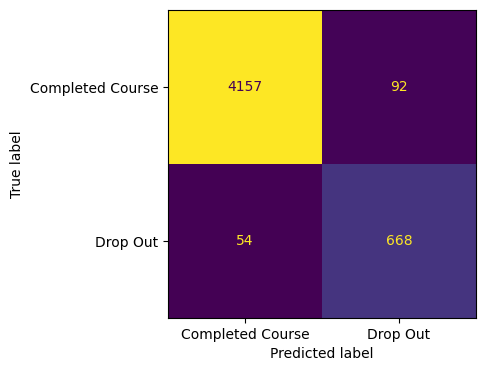

In [ ]:
predictions = best_model.predict(X_test2)
predictions = (predictions > 0.5).astype(int)
# Plot confustion matrix and performance metrics
performance_metric(y_test2, predictions, "Neural Network Model Accuracy: ")

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


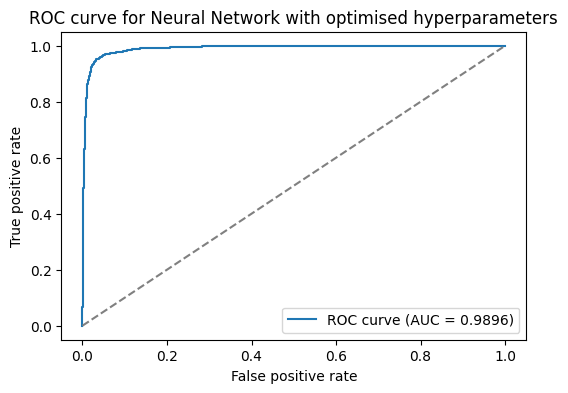

In [ ]:
predictions = best_model.predict(X_test2)

ROC_AUC(predictions,
        y_test2,
        'ROC curve for Neural Network with optimised hyperparameters')

## Neural Network Model with the Extended Dataset

Here, XGBoost will be used to classify the Study Group data CentreName, Gender, CourseLevel, IsFirstIntake, StudentDropOut, CreditWeightedAverage, ProgressionUniversity, UnauthorisedAbsenceCount, ContactHours, AttendancePercentage, and Age Features.

In [ ]:
#The dataset used for training and testing the XGBoost model with the
# extended dataset will be used again for this neural network model.
# Train the model on the minimal dataset
history = train_model(create_model(dim= X_train1.shape[1],
                                   neurons = 47),
                      X_train=X_train1,
                      y_train=y_train1,
                      X_val=X_val1,
                      y_val=y_val1)

Text(0, 0.5, 'Accuracy')

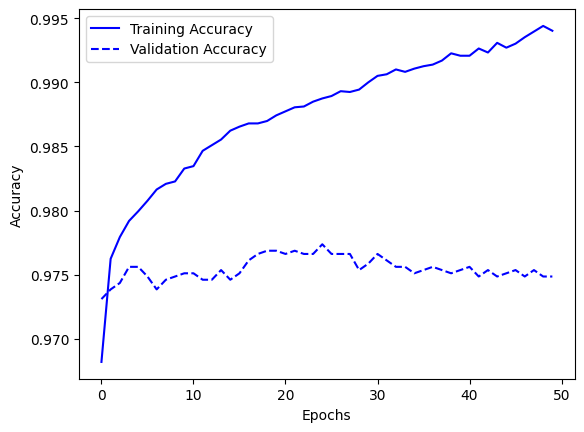

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'],
         label='Validation Accuracy',
         color='blue',
         linestyle='--')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

From the plot above, training the model with about five epochs would seem sensible, as overfitting seems to occur beyond this. Using this model, we get the metrics shown below.

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network Model Accuracy:  accuracy: 0.976061154697244
Neural Network Model Accuracy:  f1: 0.9192124915139172
              precision    recall  f1-score   support

           0     0.9893    0.9826    0.9859      4249
           1     0.9015    0.9377    0.9192       722

    accuracy                         0.9761      4971
   macro avg     0.9454    0.9601    0.9526      4971
weighted avg     0.9766    0.9761    0.9763      4971



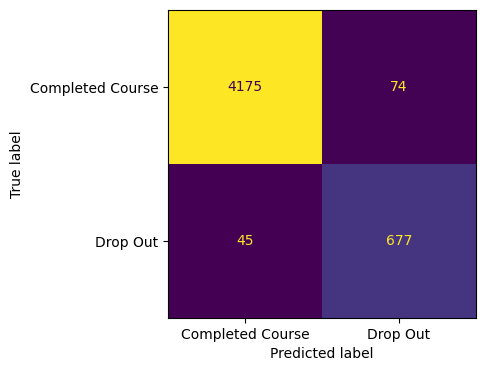

In [ ]:
# Fit the model on the whole  of the minimal training dataset with 5 epochs
model_nn = create_model(dim= X_train1.shape[1], optimizer = 'Adam')
model_nn.fit(X_train1, y_train1, epochs=5, batch_size=32, verbose=0)
predictions = model_nn.predict(X_test1)
predictions = (predictions > 0.5).astype(int)
# Plot confustion matrix and performance metrics
performance_metric(y_test1, predictions, "Neural Network Model Accuracy: ")

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


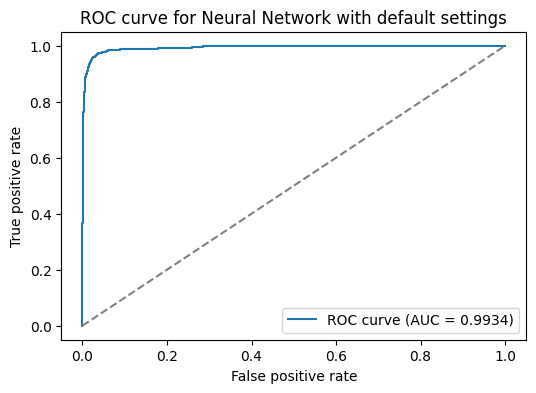

In [ ]:
predictions = model_nn.predict(X_test1)

ROC_AUC(predictions, y_test1,'ROC curve for Neural Network with default settings')

### Tuning of the Hyperparameters with the Extended Dataset

Here, the hyperparameters for the neural network model will be tuned in the same manner as those used for the minimal dataset.

In [ ]:
# Iterate through different numbers of neurons. Note that due to the model architecture
# in create_model this will gave layer 1 = 2*neurons and layer 2 = neurons
neuron_list = [20, 40, 60, 90, 120, 150]
best_f1 = 0
best_model = None
best_param = None
for num_neurons in neuron_list:
    print(f"\nTraining model with {num_neurons} neurons...")
    model = create_model(dim=X_train1.shape[1],
                         optimizer='adam',
                         neurons=num_neurons,
                         activation='relu')

    # Train the model.
    model.fit(X_train1, y_train1,
              epochs=15,
              batch_size=32,
              validation_data=(X_val1, y_val1),
              verbose=0)

    # Evaluate the model.
    _, accuracy = model.evaluate(X_test1, y_test1, verbose=0)
    predictions = model.predict(X_test1)
    predictions = (predictions > 0.5).astype(int)
    f1_sc = f1_score(y_test1, predictions)
    print(f"Model with {num_neurons} layers - Test accuracy: {accuracy}")
    print(f"Model with {num_neurons} layers - f1 score: {f1_sc}")

    # If current model has higher accuracy, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = num_neurons

print(f"\nBest model found with f1 score: {best_f1} and {best_param} neurons")


Training model with 20 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model with 20 layers - Test accuracy: 0.976664662361145
Model with 20 layers - f1 score: 0.9201101928374655

Training model with 40 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model with 40 layers - Test accuracy: 0.9760611653327942
Model with 40 layers - f1 score: 0.9183253260123542

Training model with 60 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model with 60 layers - Test accuracy: 0.9790786504745483
Model with 60 layers - f1 score: 0.9282758620689655

Training model with 90 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model with 90 layers - Test accuracy: 0.9780728220939636
Model with 90 layers - f1 score: 0.925085910652921

Training model with 120 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model with 120 layers - Test accuracy: 0.9772681593894958
Model with 120 layers - f1 score: 0.9212543554006969

Training model with 150 neurons...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

Here, 60 neurons were found to be optimal for layer 2 and 120 for layer 1, so they will be used for the next tuning phase, which will focus on the optimiser.

In [ ]:
# Iterate through different optimisers.
optimizer_list = ['adam', 'rmsprop']
best_f1 = 0
best_model = None
best_param = None
for optimizer in optimizer_list:
    print(f"\nTraining model with {optimizer} optimizer...")
    model = create_model(dim=X_train1.shape[1],
                         optimizer=optimizer,
                         neurons=60,
                         activation='relu')

    # Train the model.
    model.fit(X_train1, y_train1,
              epochs=15,
              batch_size=32,
              validation_data=(X_val1, y_val1),
              verbose=0)

    # Evaluate the model.
    _, accuracy = model.evaluate(X_test1, y_test1, verbose=0)
    predictions = model.predict(X_test1)
    predictions = (predictions > 0.5).astype(int)
    f1_sc = f1_score(y_test2, predictions)
    print(f"Model with {optimizer} optimizer - Test accuracy: {accuracy}")
    print(f"Model with {optimizer} optimizer - f1 score: {f1_sc}")

    # If current model has higher accuracy, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = optimizer

print(f"\nBest model found with f1 score: {best_f1} using {best_param} optimiser")


Training model with adam optimizer...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model with adam optimizer - Test accuracy: 0.9772681593894958
Model with adam optimizer - f1 score: 0.9231815091774304

Training model with rmsprop optimizer...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model with rmsprop optimizer - Test accuracy: 0.9754576683044434
Model with rmsprop optimizer - f1 score: 0.9171195652173914

Best model found with f1 score: 0.9231815091774304 using adam optimiser


Here, the Adam optimiser was found to be marginally better for creating the neural network model, so it will be used for the next tuning phase, focusing on the activation functions.

In [ ]:
# Iterate through different activation functions.
activation_list = ['relu', 'leaky_relu', 'tanh']
best_f1 = 0
best_model = None
best_param = None
for activation in activation_list:
    print(f"\nTraining model with {activation} activation...")
    model = create_model(dim=X_train1.shape[1],
                         optimizer='adam',
                         neurons=60,
                         activation=activation)

    # Train the model.
    model.fit(X_train1, y_train1,
              epochs=15,
              batch_size=32,
              validation_data=(X_val1, y_val1),
              verbose=0)

    # Evaluate the model.
    _, accuracy = model.evaluate(X_test1, y_test1, verbose=0)
    predictions = model.predict(X_test1)
    predictions = (predictions > 0.5).astype(int)
    f1_sc = f1_score(y_test1, predictions)
    print(f"Model with {activation} activation - Test accuracy: {accuracy}")
    print(f"Model with {activation} activation - f1 score: {f1_sc}")

    # If current model has higher accuracy, save it as the best model.
    if f1_sc > best_f1:
        best_f1 = f1_sc
        best_model = model
        best_param = activation

print(f"\nBest model found with f1 score: {best_f1} using {best_param} activation function")


Training model with relu activation...
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model with relu activation - Test accuracy: 0.9776704907417297
Model with relu activation - f1 score: 0.9240246406570842

Training model with leaky_relu activation...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model with leaky_relu activation - Test accuracy: 0.9770669937133789
Model with leaky_relu activation - f1 score: 0.9213793103448276

Training model with tanh activation...
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model with tanh activation - Test accuracy: 0.9784751534461975
Model with tanh activation - f1 score: 0.925642807505212

Best model found with f1 score: 0.925642807505212 using tanh activation function


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network Model Accuracy:  accuracy: 0.9784751559042446
Neural Network Model Accuracy:  f1: 0.925642807505212
              precision    recall  f1-score   support

           0     0.9868    0.9880    0.9874      4249
           1     0.9289    0.9224    0.9256       722

    accuracy                         0.9785      4971
   macro avg     0.9579    0.9552    0.9565      4971
weighted avg     0.9784    0.9785    0.9784      4971



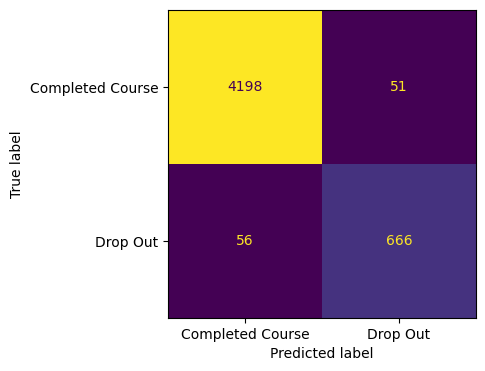

In [ ]:
predictions = best_model.predict(X_test1)
predictions = (predictions > 0.5).astype(int)
# Plot confustion matrix and performance metrics
performance_metric(y_test1, predictions, "Neural Network Model Accuracy: ")

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


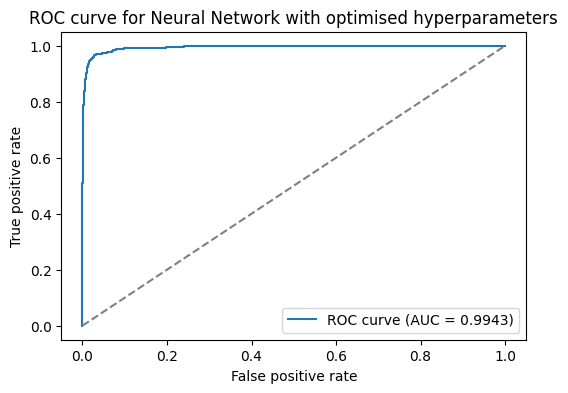

In [ ]:
predictions = best_model.predict(X_test1)

ROC_AUC(predictions,
        y_test2,
        'ROC curve for Neural Network with optimised hyperparameters')

#Summary and Next Steps

In summary, the XGBoost models performed slightly better overall than the neural network models, with the best F1 score for these two approaches being 0.9338 vs 0.9256. It is noted that the neural networks produced much more balanced precision and recall scores than XGBoost. However, the differences between the two were marginal, and the XGBoost model is probably preferable due to its lower computational complexity and better interpretability. However, it should be noted that the models were not fully optimised due to computational constraints. Further work on student dropout prediction should focus on:

* **Investigating missing values** - The nature of these
missing values is not random, and the fact that they are missing seems to be related to the class. This should be investigated further so that this valuable information is not lost.

* **Investigate the use of other features** - The original dataset has 35 features, not including the CompletedCourse feature, but only ten are used. Some of these features may have more predictive value than those used.

* **Investigate feature engineering** - Further to the idea above, it would also be prudent to investigate possible feature engineering and dimension reduction.   The count plots of the categorical features (Figure 3) indicated that there may be some colinearity between the CentreName and ProgressionUniversity. Reducing features to compensate for this colinearity and including features with better predictive power will help reduce model complexity and improve performance.

* **Better optimisation** - Due to Colab's constraints, a heuristic approach to optimisation was undertaken. With more computational resources, GridSearchCV could be fully utilised to optimise the hyperparameters.

* **Regularisation** - This was not attempted during this work but should be investigated to reduce overfitting and improve the model's ability to handle new data.
